In [ ]:
pip install pandas numpy matplotlib pandas jupyter 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

SAMPLE_NUMBER = 213

from sklearn.linear_model import LinearRegression # linear regression
from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import mean_squared_error # calculate error

In [62]:
def read_filename(filename):

	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=None)

	# EG, FILENAME='PL_PC_records/PL and PC record-535-b-2.txt' --> ID_STRING='535-b-2.txt'
	id_string = filename.split('/')[2]
	cc = id_string.split('-') # split into parts with - inbetween

	wavelength = cc[0] # wavelength
	location = cc[3] # background (b) or nv-center (nv)
	voltage = cc[2]

	# file has rows for columns, thus transpose
	df = df.transpose()

	# assign column meaning
	df['Laser Power (V)'] = df[0] # the header became the index after transposition
	df['PL (counts/s)'] = df[1]
	df['PC (pA)'] = df[2]

	# make the index a simple counter
	df = df.reset_index()

	# keep columns of interest
	df = df[['Laser Power (V)', 'PL (counts/s)', 'PC (pA)']]

	# assign identifiers to dataframe
	df['Wavelength'] = int(wavelength)
	df['Location'] = location
	df['Voltage'] = voltage

	df['Laser Power (V)'] = df['Laser Power (V)'].astype(float)
	df['PL (counts/s)'] = df['PL (counts/s)'].astype(float)
	df['PC (pA)'] =  df['PC (pA)'].astype(float)

	return df, wavelength, location, voltage

In [91]:
nv_df_0V, _ , _ , _ = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-SATCurve-0V-NVRIK.txt')
nv_df_0V_BG, _ , _ , _ = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-SATCurve-0V-NVRIK-bg.txt')
nv_df_20V, _ , _ , _ = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-SATCurve-20V-NVRIK.txt')
nv_df_m20V, _ , _ , _ = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-SATCurve-m20V-NVRIK.txt')

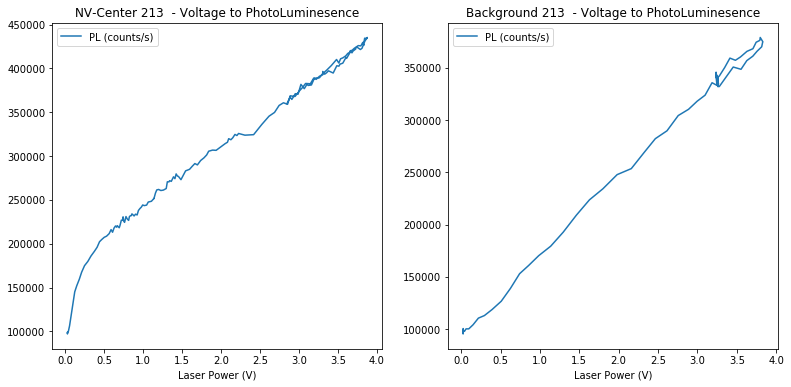

In [65]:
# showcase Laser Power x PL
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,6))  # 1 row, 2 columns
nv_df_0V.plot(x='Laser Power (V)', y='PL (counts/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")
nv_df_0V_BG.plot(x='Laser Power (V)', y='PL (counts/s)', ax=ax2, title=f"Background {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")

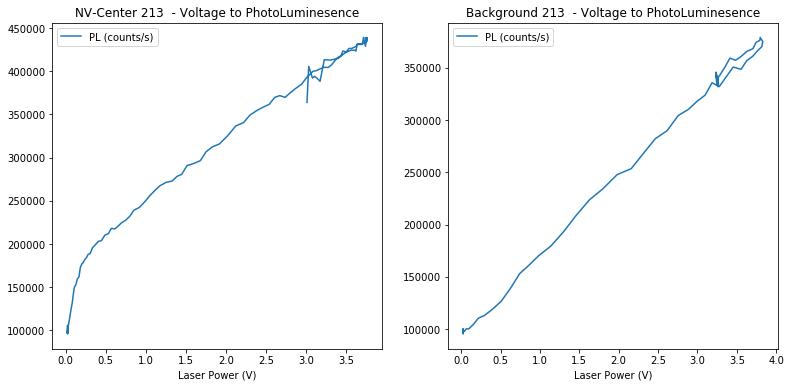

In [66]:
# showcase Laser Power x PL
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,6))  # 1 row, 2 columns
nv_df_20V.plot(x='Laser Power (V)', y='PL (counts/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")
nv_df_0V_BG.plot(x='Laser Power (V)', y='PL (counts/s)', ax=ax2, title=f"Background {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")

mean_absolute_error: 3946.719539521221  - max_error: 11411.060365150217


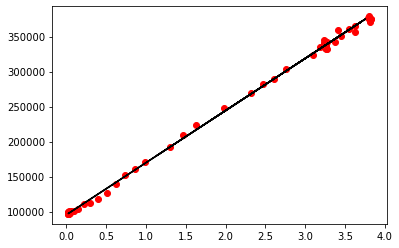

In [67]:
from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import max_error, mean_absolute_error # calculate error

# fit background PL(V) function, should be linear
X = nv_df_0V_BG['Laser Power (V)'].to_numpy()
y = nv_df_0V_BG['PL (counts/s)'].to_numpy()

# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
X = X.reshape(-1, 1)

# split dataset into 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# fit regression
reg = LinearRegression().fit(X_train, y_train)

# predict on unseen values (X_test)
y_pred = reg.predict(X_test)

# plot input values, and fit
plt.scatter(X_train, y_train,color='r') 
plt.plot(X_test, y_pred,color='k')

print("mean_absolute_error:", mean_absolute_error(y_test,y_pred), " - max_error:", max_error(y_test,y_pred))

This looks good enough! Let's subtract the **background PL counts** from NV-Center Counts, using the trained logistic regression.

In [94]:
# conver the column into a readily base for regressing
laser_power_nv = nv_df_0V['Laser Power (V)'].to_numpy().reshape(-1,1)

# apply PL-count Regression
nv_df_0V['PL_background'] = reg.predict(laser_power_nv)

# subtract background counts from NV counts
nv_df_0V['PL_actual (#/s)'] = nv_df_0V['PL (counts/s)'] - nv_df_0V['PL_background']

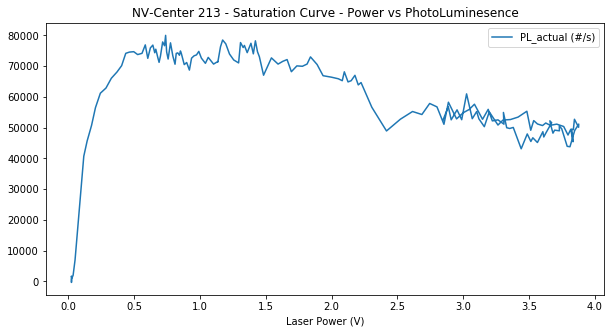

In [95]:
fig, (ax1) = plt.subplots(1,1, figsize=(10,5))  # 1 row, 2 columns
nv_df_0V.plot(x='Laser Power (V)', y='PL_actual (#/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power vs PhotoLuminesence")

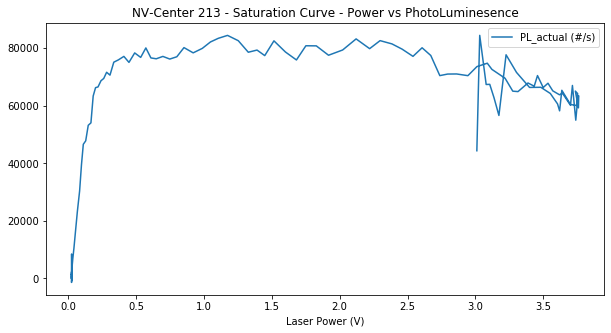

In [96]:
# conver the column into a readily base for regressing
laser_power_nv = nv_df_20V['Laser Power (V)'].to_numpy().reshape(-1,1)

# apply PL-count Regression
nv_df_20V['PL_background'] = reg.predict(laser_power_nv)

# subtract background counts from NV counts
nv_df_20V['PL_actual (#/s)'] = nv_df_20V['PL (counts/s)'] - nv_df_20V['PL_background']

fig, (ax1) = plt.subplots(1,1, figsize=(10,5))  # 1 row, 2 columns
nv_df_20V.plot(x='Laser Power (V)', y='PL_actual (#/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power vs PhotoLuminesence")

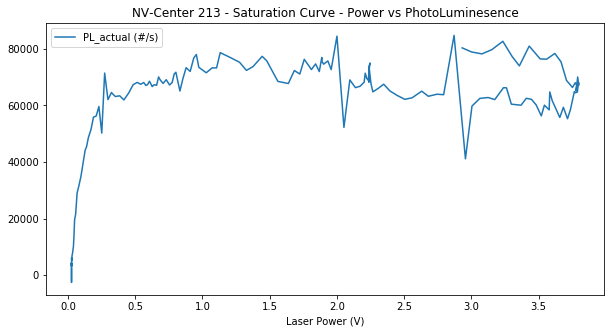

In [97]:
# conver the column into a readily base for regressing
laser_power_nv = nv_df_m20V['Laser Power (V)'].to_numpy().reshape(-1,1)

# apply PL-count Regression
nv_df_m20V['PL_background'] = reg.predict(laser_power_nv)

# subtract background counts from NV counts
nv_df_m20V['PL_actual (#/s)'] = nv_df_m20V['PL (counts/s)'] - nv_df_m20V['PL_background']

fig, (ax1) = plt.subplots(1,1, figsize=(10,5))  # 1 row, 2 columns
nv_df_m20V.plot(x='Laser Power (V)', y='PL_actual (#/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power vs PhotoLuminesence")

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression # linear regression

def func_to_fit(x, b, c, d, e):
    return ((x**2) + b*x) / (c*(x**2) + d*x + e)

In [122]:
def get_fit_params(df):
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_actual (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(func_to_fit, x, y, bounds=[0, np.Inf])
	
	return popt, pcov

Fit laser power

In [123]:
x = np.array([0.09477, 3.72198]).reshape(-1, 1)
y = [0.519, 26.5]
laser_power_v_to_mW = LinearRegression().fit(x, y)

In [116]:
nv_df_0V['Laser Power (mW)'] = laser_power_v_to_mW.predict(nv_df_0V['Laser Power (V)'].to_numpy().reshape(-1,1))
nv_df_20V['Laser Power (mW)'] = laser_power_v_to_mW.predict(nv_df_20V['Laser Power (V)'].to_numpy().reshape(-1,1))
nv_df_m20V['Laser Power (mW)'] = laser_power_v_to_mW.predict(nv_df_m20V['Laser Power (V)'].to_numpy().reshape(-1,1))

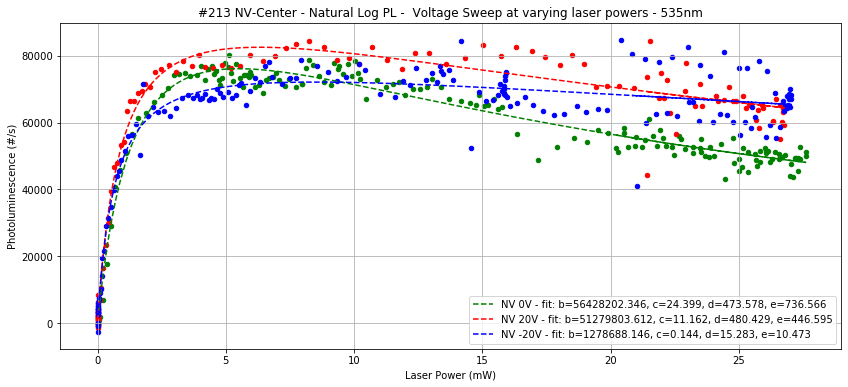

In [127]:
df_0V = nv_df_0V
df_20V = nv_df_20V
df_m20V = nv_df_m20V

fit_0, _ = get_fit_params(df_0V)
fit_20, _ = get_fit_params(df_20V)
fit_m20, _ = get_fit_params(df_m20V)

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df_0V.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c='green', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")
df_20V.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c='red', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")
df_m20V.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c='blue', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

x_1 = df_0V['Laser Power (mW)'].to_numpy()
x_2 = df_20V['Laser Power (mW)'].to_numpy()
x_3 = df_m20V['Laser Power (mW)'].to_numpy()

plt.plot(x_1, func_to_fit(x_1, *fit_0), 'g--', c='green', label='NV 0V - fit: b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(fit_0))
plt.plot(x_2, func_to_fit(x_2, *fit_20), 'g--', c='red', label='NV 20V - fit: b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(fit_20))
plt.plot(x_3, func_to_fit(x_3, *fit_m20), 'g--',  c='blue', label='NV -20V - fit: b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(fit_m20))

ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Natural Log PL -  Voltage Sweep at varying laser powers - 535nm")
ax1.set_xlabel("Laser Power (mW)")
ax1.set_ylabel("Photoluminescence (#/s)")
ax1.legend()
ax1.grid(True)

plt.legend()

## PL-Voltage Sweeps

In [152]:
def read_filename(filename):
	
	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=0)

	# rename columns, and make sure we only keep the two that we're interested in
	df.columns = ['Voltage (V)', 'PL (Counts/s)', '']
	df = df[['Voltage (V)', 'PL (Counts/s)']]

	# convert column values to float
	df['Voltage (V)'] = df['Voltage (V)'].astype(float)
	df['PL (Counts/s)'] = df['PL (Counts/s)'].astype(float)

	return df

In [153]:
df_535_2p5mW_100ms_6_avg = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-2.5mW-100ms-6avg-NVRIK.txt')
df_535_5mW_400ms_2_avg_1 = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-5mW-400ms-2avg-trash.txt')
df_535_5mW_100ms_2_avg_2 = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-5mW-100ms-2avg-trash-2.txt')
df_535_5mW_100ms_2_avg_3 = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-5mW-100ms-2avg-trash-3.txt')

df_535_2p5mW_100ms_6_avg = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-2.5mW-100ms-6avg-NVRIK.txt')
df_535_2p5mW_100ms_6_avg['Laser Power (mW)'] = 2.5
df_535_5mW_100ms_6_avg = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-5mW-100ms-6avg-NVRIK.txt')
df_535_5mW_100ms_6_avg['Laser Power (mW)'] = 5
df_535_10mW_100ms_6_avg = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-10mW-100ms-6avg-NVRIK.txt')
df_535_10mW_100ms_6_avg['Laser Power (mW)'] = 10
df_535_15mW_100ms_6_avg = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-15mW-100ms-6avg-NVRIK.txt')
df_535_15mW_100ms_6_avg['Laser Power (mW)'] = 15
df_535_20mW_100ms_6_avg = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-20mW-100ms-6avg-NVRIK.txt')
df_535_20mW_100ms_6_avg['Laser Power (mW)'] = 20
df_535_25mW_100ms_6_avg = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-25mW-100ms-6avg-NVRIK.txt')
df_535_25mW_100ms_6_avg['Laser Power (mW)'] = 25

df_535_26p5mW_100ms_6_avg = read_filename('./12h20-crossPoint-Vsweep-SATCurve/535-26.5mW-100ms-6avg-NVRIK.txt')

# dfs = [
# 	df_535_2p5mW_100ms_6_avg,
# 	df_535_5mW_400ms_2_avg_1,
# 	df_535_5mW_100ms_2_avg_2,
# 	df_535_5mW_100ms_2_avg_3,
# 	df_535_5mW_100ms_6_avg,
# 	df_535_10mW_100ms_6_avg,
# 	df_535_15mW_100ms_6_avg,
# 	df_535_20mW_100ms_6_avg,
# 	df_535_25mW_100ms_6_avg,
# 	df_535_26p5mW_100ms_6_avg
# ]

In [21]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

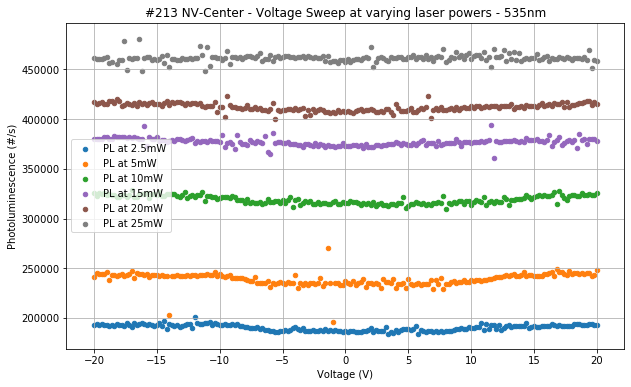

In [56]:
dfs = [
	df_535_2p5mW_100ms_6_avg,
	df_535_5mW_100ms_6_avg,
	df_535_10mW_100ms_6_avg,
	df_535_15mW_100ms_6_avg,
	df_535_20mW_100ms_6_avg,
	df_535_25mW_100ms_6_avg,
]

plasma = cm.get_cmap('tab10', len(dfs)+2)
colors = plasma(range(len(dfs)))

fig, (ax1) = plt.subplots(1,1, figsize=(10,6))  # 1 row, 2 columns

for ii, df in enumerate(dfs):
	laser_power = df['Laser Power (mW)'][0]
	df.plot.scatter(x='Voltage (V)', y='PL (Counts/s)', c=colors[ii], ax=ax1, legend=True, label=f"PL at {laser_power}mW")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='blue', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='red', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Voltage Sweep at varying laser powers - 535nm")
ax1.set_xlabel("Voltage (V)")
ax1.set_ylabel("Photoluminescence (#/s)")
ax1.legend()
ax1.grid(True)

## Level All Curves

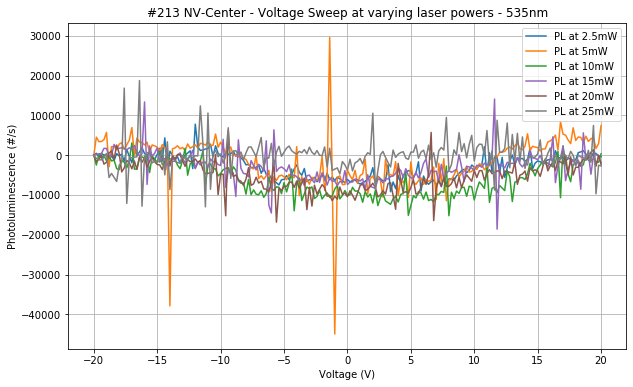

In [129]:
dfs = [
	df_535_2p5mW_100ms_6_avg,
	df_535_5mW_100ms_6_avg,
	df_535_10mW_100ms_6_avg,
	df_535_15mW_100ms_6_avg,
	df_535_20mW_100ms_6_avg,
	df_535_25mW_100ms_6_avg,
]

for ii, df in enumerate(dfs):
	df['PL (Counts/s)'] -= df['PL (Counts/s)'][0]

plasma = cm.get_cmap('tab10', len(dfs)+2)
colors = plasma(range(len(dfs)))

fig, (ax1) = plt.subplots(1,1, figsize=(10,6))  # 1 row, 2 columns

for ii, df in enumerate(dfs):
	laser_power = df['Laser Power (mW)'][0]
	df.plot(x='Voltage (V)', y='PL (Counts/s)', c=colors[ii], ax=ax1, legend=True, label=f"PL at {laser_power}mW")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='blue', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='red', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Voltage Sweep at varying laser powers - 535nm")
ax1.set_xlabel("Voltage (V)")
ax1.set_ylabel("Photoluminescence (#/s)")
ax1.legend()
ax1.grid(True)

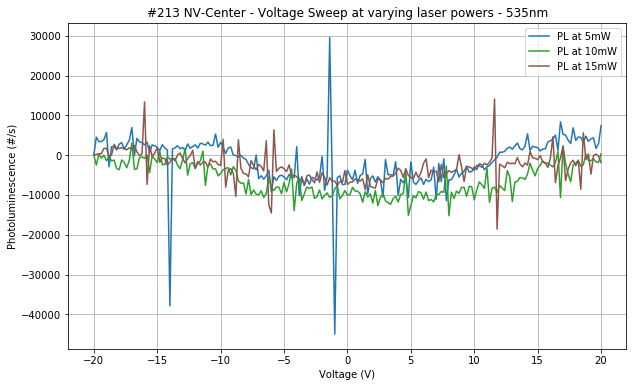

In [134]:
dfs = [
	df_535_5mW_100ms_6_avg,
	df_535_10mW_100ms_6_avg,
	df_535_15mW_100ms_6_avg,
]

for ii, df in enumerate(dfs):
	df['PL (Counts/s)'] -= df['PL (Counts/s)'][0]

plasma = cm.get_cmap('tab10', len(dfs)+2)
colors = plasma(range(len(dfs)))

fig, (ax1) = plt.subplots(1,1, figsize=(10,6))  # 1 row, 2 columns

for ii, df in enumerate(dfs):
	laser_power = df['Laser Power (mW)'][0]
	df.plot(x='Voltage (V)', y='PL (Counts/s)', c=colors[ii], ax=ax1, legend=True, label=f"PL at {laser_power}mW")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='blue', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='red', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Voltage Sweep at varying laser powers - 535nm")
ax1.set_xlabel("Voltage (V)")
ax1.set_ylabel("Photoluminescence (#/s)")
ax1.legend()
ax1.grid(True)

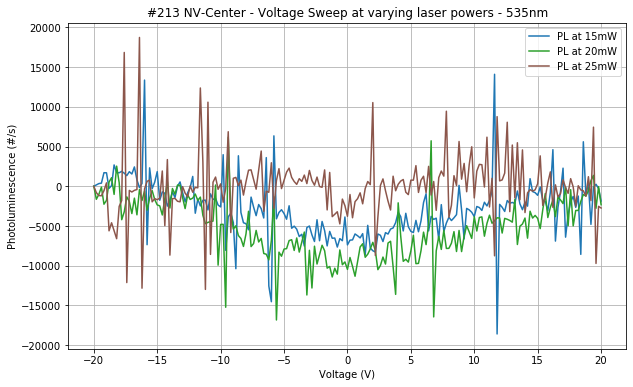

In [135]:
dfs = [
	df_535_15mW_100ms_6_avg,
	df_535_20mW_100ms_6_avg,
	df_535_25mW_100ms_6_avg,
]

for ii, df in enumerate(dfs):
	df['PL (Counts/s)'] -= df['PL (Counts/s)'][0]

plasma = cm.get_cmap('tab10', len(dfs)+2)
colors = plasma(range(len(dfs)))

fig, (ax1) = plt.subplots(1,1, figsize=(10,6))  # 1 row, 2 columns

for ii, df in enumerate(dfs):
	laser_power = df['Laser Power (mW)'][0]
	df.plot(x='Voltage (V)', y='PL (Counts/s)', c=colors[ii], ax=ax1, legend=True, label=f"PL at {laser_power}mW")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='blue', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='red', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Voltage Sweep at varying laser powers - 535nm")
ax1.set_xlabel("Voltage (V)")
ax1.set_ylabel("Photoluminescence (#/s)")
ax1.legend()
ax1.grid(True)

## Smoothing

In [137]:
from scipy.signal import savgol_filter

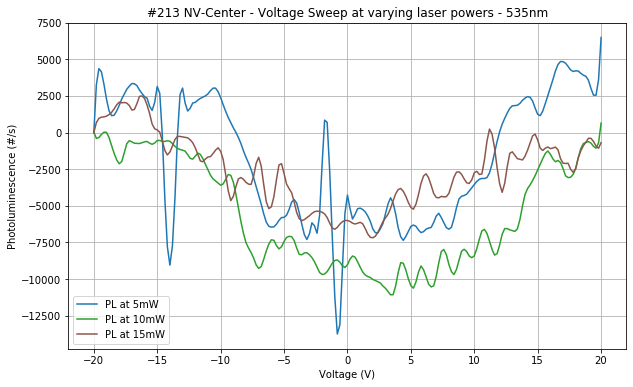

In [141]:
dfs = [
	df_535_5mW_100ms_6_avg,
	df_535_10mW_100ms_6_avg,
	df_535_15mW_100ms_6_avg,
]

for ii, df in enumerate(dfs):
	df['PL (Counts/s)'] -= df['PL (Counts/s)'][0]
	df['PL (Counts/s)'] = savgol_filter(df['PL (Counts/s)'], 9, 4)


plasma = cm.get_cmap('tab10', len(dfs)+2)
colors = plasma(range(len(dfs)))

fig, (ax1) = plt.subplots(1,1, figsize=(10,6))  # 1 row, 2 columns

for ii, df in enumerate(dfs):
	laser_power = df['Laser Power (mW)'][0]
	df.plot(x='Voltage (V)', y='PL (Counts/s)', c=colors[ii], ax=ax1, legend=True, label=f"PL at {laser_power}mW")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='blue', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='red', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Voltage Sweep at varying laser powers - 535nm")
ax1.set_xlabel("Voltage (V)")
ax1.set_ylabel("Photoluminescence (#/s)")
ax1.legend()
ax1.grid(True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


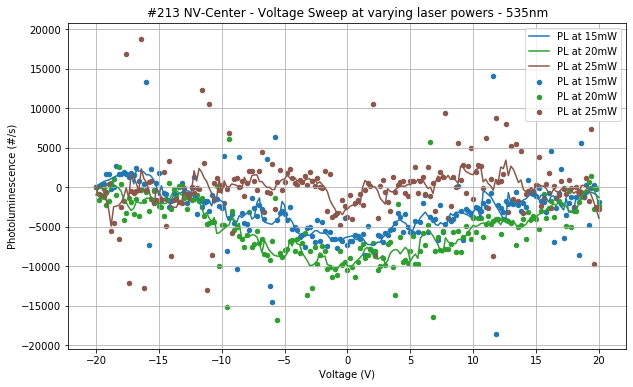

In [158]:
dfs = [
	df_535_15mW_100ms_6_avg.copy(),
	df_535_20mW_100ms_6_avg.copy(),
	df_535_25mW_100ms_6_avg.copy(),
]

for ii, df in enumerate(dfs):
	df['PL (Counts/s)'] -= df['PL (Counts/s)'][0]
	df['PL (Counts/s) s'] = savgol_filter(df['PL (Counts/s)'], 11, 3)


plasma = cm.get_cmap('tab10', len(dfs)+2)
colors = plasma(range(len(dfs)))

fig, (ax1) = plt.subplots(1,1, figsize=(10,6))  # 1 row, 2 columns

for ii, df in enumerate(dfs):
	laser_power = df['Laser Power (mW)'][0]
	df.plot.scatter(x='Voltage (V)', y='PL (Counts/s)', c=colors[ii], ax=ax1, legend=True, label=f"PL at {laser_power}mW")
	df.plot(x='Voltage (V)', y='PL (Counts/s) s', c=colors[ii], ax=ax1, legend=True, label=f"PL at {laser_power}mW")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='blue', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")
	# df.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', c='red', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Voltage Sweep at varying laser powers - 535nm")
ax1.set_xlabel("Voltage (V)")
ax1.set_ylabel("Photoluminescence (#/s)")
ax1.legend()
ax1.grid(True)

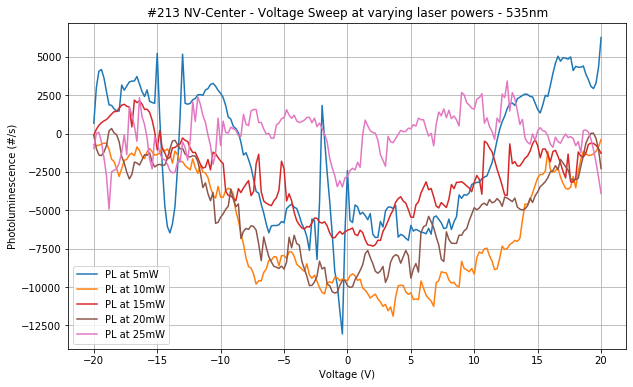

In [161]:
dfs = [
	df_535_5mW_100ms_6_avg.copy(),
	df_535_10mW_100ms_6_avg.copy(),
	df_535_15mW_100ms_6_avg.copy(),
	df_535_20mW_100ms_6_avg.copy(),
	df_535_25mW_100ms_6_avg.copy(),
]

for ii, df in enumerate(dfs):
	df['PL (Counts/s)'] -= df['PL (Counts/s)'][0]
	df['PL (Counts/s) s'] = savgol_filter(df['PL (Counts/s)'], 11, 3)


plasma = cm.get_cmap('tab10', len(dfs)+2)
colors = plasma(range(len(dfs)))

fig, (ax1) = plt.subplots(1,1, figsize=(10,6))  # 1 row, 2 columns

for ii, df in enumerate(dfs):
	laser_power = df['Laser Power (mW)'][0]
	df.plot(x='Voltage (V)', y='PL (Counts/s) s', c=colors[ii], ax=ax1, legend=True, label=f"PL at {laser_power}mW")

ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Voltage Sweep at varying laser powers - 535nm")
ax1.set_xlabel("Voltage (V)")
ax1.set_ylabel("Photoluminescence (#/s)")
ax1.legend()
ax1.grid(True)

- How are 10 mW and 20mW at the same PL?
- 10 mW cross point at 0V is not visible in this stack
- [-5,5] V range of 25mW should go lower according to saturation curve, but here it's the same (0)
- Huge difference between 20mW and 25mW in [-5. 5] V range. On saturation curve, this is actually to be expected
- 